<a href="https://colab.research.google.com/github/DhrumilPrajapati03/Hyperparameter-tuning_of_U-NET/blob/main/Unet_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Building

In [1]:
!pip install rasterio geopandas tqdm matplotlib scikit-learn tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 30.7 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from sklearn.metrics import classification_report, confusion_matrix
import rasterio
from rasterio.plot import show
import glob
from datetime import datetime
import time
from tqdm import tqdm
import gc

In [3]:
# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("Using GPU for training")
else:
    print("No GPU found, using CPU (this will be much slower)")

Num GPUs Available:  1
Using GPU for training


In [4]:
# Step 2: Define Directories and Settings

# Use directories provided by the user
img_dir = "/content/drive/MyDrive/OSCD_DATASET/Onera Satellite Change Detection dataset - Images"
test_dir = "/content/drive/MyDrive/OSCD_DATASET/Onera Satellite Change Detection dataset - Test Labels"
train_dir = "/content/drive/MyDrive/OSCD_DATASET/Onera Satellite Change Detection dataset - Train Labels"

In [5]:
# Check if directories exist
for dir_path in [img_dir, test_dir, train_dir]:
    if not os.path.exists(dir_path):
        print(f"Warning: Directory {dir_path} does not exist!")
    else:
        print(f"Found directory: {dir_path}")

Found directory: /content/drive/MyDrive/OSCD_DATASET/Onera Satellite Change Detection dataset - Images
Found directory: /content/drive/MyDrive/OSCD_DATASET/Onera Satellite Change Detection dataset - Test Labels
Found directory: /content/drive/MyDrive/OSCD_DATASET/Onera Satellite Change Detection dataset - Train Labels


In [6]:
# Model parameters
IMAGE_SIZE = 256      # Resize images to this size
BATCH_SIZE = 8        # Adjust based on your GPU memory
EPOCHS = 50           # Maximum number of epochs
BANDS = ['B02', 'B03', 'B04', 'B08']  # RGB + NIR

In [20]:
# Step 3: Explore Dataset Structure

def explore_dataset():
    """Explore the dataset structure and print information."""
    # List all cities in the dataset
    cities = [city for city in os.listdir(img_dir) if os.path.isdir(os.path.join(img_dir, city))]
    print(f"Found {len(cities)} cities in the dataset: {', '.join(cities)}")

    # Determine train and test cities
    train_cities = [city for city in cities if os.path.exists(os.path.join(train_dir, f"{city}"))]
    test_cities = [city for city in cities if os.path.exists(os.path.join(test_dir, f"{city}"))]

    print(f"\nTrain cities ({len(train_cities)}): {', '.join(train_cities)}")
    print(f"Test cities ({len(test_cities)}): {', '.join(test_cities)}")

    # Check the image structure for one city
    sample_city = cities[0]
    print(f"\nExploring image structure for sample city: {sample_city}")

    # Check for image folders (before and after)
    city_path = os.path.join(img_dir, sample_city)
    time_folders = [f for f in os.listdir(city_path) if os.path.isdir(os.path.join(city_path, f))]
    print(f"Time points: {', '.join(time_folders)}")

    # Check available bands for the first time point
    sample_time = time_folders[0]
    sample_time_path = os.path.join(city_path, sample_time)
    bands = os.listdir(sample_time_path)
    print(f"Available bands for {sample_time}: {', '.join(bands)}")

    # Read a sample image to get dimensions
    sample_img_path = os.path.join(sample_time_path, bands[0])
    with rasterio.open(sample_img_path) as src:
        height = src.height
        width = src.width
        dtype = src.dtypes[0]

    print(f"Sample image dimensions: {width}x{height}, Data type: {dtype}")

    return cities, train_cities, test_cities

cities, train_cities, test_cities = explore_dataset()

Found 24 cities in the dataset: beirut, nantes, bercy, mumbai, beihai, rio, saclay_e, saclay_w, chongqing, bordeaux, rennes, lasvegas, aguasclaras, pisa, paris, hongkong, dubai, valencia, norcia, cupertino, montpellier, abudhabi, brasilia, milano

Train cities (14): beirut, nantes, bercy, mumbai, beihai, saclay_e, bordeaux, rennes, aguasclaras, pisa, paris, hongkong, cupertino, abudhabi
Test cities (10): rio, saclay_w, chongqing, lasvegas, dubai, valencia, norcia, montpellier, brasilia, milano

Exploring image structure for sample city: beirut
Time points: pair, imgs_2_rect, imgs_1, imgs_1_rect, imgs_2
Available bands for pair: img1.png, img2.png
Sample image dimensions: 1070x1180, Data type: uint8


In [32]:
# Step 4: Data Loading and Preprocessing Functions

def load_sentinel_bands(city_path, time_point, selected_bands=BANDS):
    """Load selected Sentinel-2 bands for a specific city and time point."""
    bands_data = []

    for band in selected_bands:
        # Find the band file (searching with glob to handle different file extensions)
        band_pattern = os.path.join(city_path, time_point, f"{band}.*")
        band_files = glob.glob(band_pattern)

        if not band_files:
            print(f"Warning: Band {band} not found at {band_pattern}")
            continue

        band_file = band_files[0]

        # Read the band data
        with rasterio.open(band_file) as src:
            band_data = src.read(1)
            bands_data.append(band_data)

    if not bands_data:
        return None

    # Stack bands into a multi-channel image
    stacked_img = np.stack(bands_data, axis=-1)

    return stacked_img

city_name='abudhabi'
time_point='imgs_1_rect'
# Define city path
city_path = os.path.join(img_dir, city_name)
print(city_path)

image = load_sentinel_bands(city_path, time_point, selected_bands=BANDS)

# Check result
if image is not None:
    print("Loaded image shape:", image.shape)
else:
    print("Image loading failed.")

/content/drive/MyDrive/OSCD_DATASET/Onera Satellite Change Detection dataset - Images/abudhabi


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Loaded image shape: (799, 785, 4)


In [35]:
# def load_change_mask(city, cities_type="train"):
#     """Load change mask for a specific city."""
#     if cities_type == "train":
#         mask_path = os.path.join(train_dir, f"{city}.png")
#     else:  # test
#         mask_path = os.path.join(test_dir, f"{city}.png")

#     if not os.path.exists(mask_path):
#         print(f"Warning: Change mask for {city} not found at {mask_path}")
#         return None

#     # Read the mask using rasterio
#     with rasterio.open(mask_path) as src:
#         mask = src.read(1)

#     # Ensure binary mask (0 or 1)
#     mask = (mask > 0).astype(np.uint8)

#     return mask

def load_change_mask(city, cities_type="train"):
    """Load change mask for a specific city."""
    if cities_type == "train":
        mask_path = os.path.join(train_dir, city, "cm", "cm.png")
    else:  # test
        mask_path = os.path.join(test_dir, city, "cm", "cm.png")

    if not os.path.exists(mask_path):
        print(f"Warning: Change mask for {city} not found at {mask_path}")
        return None

    # Read the mask using rasterio
    with rasterio.open(mask_path) as src:
        mask = src.read(1)

    # Ensure binary mask (0 or 1)
    mask = (mask > 0).astype(np.uint8)

    return mask

mask = load_change_mask("abudhabi", cities_type="train")

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [37]:
# def prepare_image_pair(city, resize=True):
#     """Prepare image pair (before and after) for a city."""
#     city_path = os.path.join(img_dir, city)

#     # Find time point folders (usually 'imgs_1' and 'imgs_2')
#     time_folders = sorted([
#         f for f in os.listdir(city_path)
#         if os.path.isdir(os.path.join(city_path, f)) and 'imgs_' in f
#     ])

#     if len(time_folders) < 2:
#         print(f"Error: Expected at least 2 time points for {city}, found {len(time_folders)}")
#         return None, None

#     # Load images for time 1 and time 2
#     img_t1 = load_sentinel_bands(city_path, time_folders[0])
#     img_t2 = load_sentinel_bands(city_path, time_folders[1])

#     if img_t1 is None or img_t2 is None:
#         return None, None

#     # Check if both images have the same shape
#     if img_t1.shape != img_t2.shape:
#         print(f"Warning: Images for {city} have different shapes: {img_t1.shape} vs {img_t2.shape}")
#         # Resize to match (this is a simplification, proper resampling might be needed)
#         min_height = min(img_t1.shape[0], img_t2.shape[0])
#         min_width = min(img_t1.shape[1], img_t2.shape[1])
#         img_t1 = img_t1[:min_height, :min_width, :]
#         img_t2 = img_t2[:min_height, :min_width, :]

#     # Normalize to [0, 1]
#     img_t1 = img_t1.astype(np.float32) / 10000.0  # Sentinel-2 data typically uses 10000 as max value
#     img_t2 = img_t2.astype(np.float32) / 10000.0

#     # Clip values to [0, 1] range in case of anomalies
#     img_t1 = np.clip(img_t1, 0, 1)
#     img_t2 = np.clip(img_t2, 0, 1)

#     # Resize if needed
#     if resize and (img_t1.shape[0] != IMAGE_SIZE or img_t1.shape[1] != IMAGE_SIZE):
#         img_t1 = tf.image.resize(img_t1, (IMAGE_SIZE, IMAGE_SIZE)).numpy()
#         img_t2 = tf.image.resize(img_t2, (IMAGE_SIZE, IMAGE_SIZE)).numpy()

#     return img_t1, img_t2
def prepare_image_pair(city, resize=True):
    """Prepare image pair (before and after) for a city."""
    city_path = os.path.join(img_dir, city)

    # Use specific folder names instead of pattern matching
    time_folders = ["imgs_1_rect", "imgs_2_rect"]
    full_paths = [os.path.join(city_path, tfolder) for tfolder in time_folders]

    # Check both folders exist
    if not all(os.path.isdir(path) for path in full_paths):
        print(f"Error: One or both time folders not found for {city}: {time_folders}")
        return None, None

    # Load images for time 1 and time 2
    img_t1 = load_sentinel_bands(city_path, "imgs_1_rect")
    img_t2 = load_sentinel_bands(city_path, "imgs_2_rect")

    if img_t1 is None or img_t2 is None:
        return None, None

    # Check if both images have the same shape
    if img_t1.shape != img_t2.shape:
        print(f"Warning: Images for {city} have different shapes: {img_t1.shape} vs {img_t2.shape}")
        min_height = min(img_t1.shape[0], img_t2.shape[0])
        min_width = min(img_t1.shape[1], img_t2.shape[1])
        img_t1 = img_t1[:min_height, :min_width, :]
        img_t2 = img_t2[:min_height, :min_width, :]

    # Normalize to [0, 1]
    img_t1 = img_t1.astype(np.float32) / 10000.0
    img_t2 = img_t2.astype(np.float32) / 10000.0

    # Clip values to [0, 1] to handle anomalies
    img_t1 = np.clip(img_t1, 0, 1)
    img_t2 = np.clip(img_t2, 0, 1)

    # Resize if needed
    if resize and (img_t1.shape[0] != IMAGE_SIZE or img_t1.shape[1] != IMAGE_SIZE):
        img_t1 = tf.image.resize(img_t1, (IMAGE_SIZE, IMAGE_SIZE)).numpy()
        img_t2 = tf.image.resize(img_t2, (IMAGE_SIZE, IMAGE_SIZE)).numpy()

    return img_t1, img_t2

city_name = "abudhabi"
img_t1, img_t2 = prepare_image_pair(city_name)

# Check result
if img_t1 is not None and img_t2 is not None:
    print("Before image shape:", img_t1.shape)
    print("After image shape:", img_t2.shape)
else:
    print("Image pair loading failed.")

Before image shape: (256, 256, 4)
After image shape: (256, 256, 4)


In [38]:
def data_generator(cities_list, cities_type="train", batch_size=BATCH_SIZE, shuffle=True):
    """Generator to yield batches of image pairs and masks."""
    n_cities = len(cities_list)
    indices = np.arange(n_cities)

    if shuffle:
        np.random.shuffle(indices)

    batch_images = []
    batch_masks = []

    for idx in indices:
        city = cities_list[idx]

        # Load image pair
        img_t1, img_t2 = prepare_image_pair(city)
        if img_t1 is None or img_t2 is None:
            continue

        # Load mask
        mask = load_change_mask(city, cities_type)
        if mask is None:
            continue

        # Resize mask if needed
        if mask.shape[0] != IMAGE_SIZE or mask.shape[1] != IMAGE_SIZE:
            mask = tf.image.resize(
                mask[..., np.newaxis],
                (IMAGE_SIZE, IMAGE_SIZE),
                method='nearest'
            ).numpy().squeeze()

        # Concatenate images from both dates
        img_pair = np.concatenate([img_t1, img_t2], axis=-1)

        batch_images.append(img_pair)
        batch_masks.append(mask)

        if len(batch_images) == batch_size:
            X = np.array(batch_images)
            y = np.array(batch_masks)[..., np.newaxis]

            yield X, y

            batch_images = []
            batch_masks = []

    # Yield last incomplete batch if non-empty
    if batch_images:
        X = np.array(batch_images)
        y = np.array(batch_masks)[..., np.newaxis]

        yield X, y

In [39]:
# Step 5: Build U-Net Model

def build_unet_model(input_shape):
    """Build U-Net model for change detection."""

    # Input layer
    inputs = Input(input_shape)

    # Encoder path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bridge
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder path
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    # Output layer
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [40]:
# Step 6: Train Model

def train_model(model, train_cities, val_cities, steps_per_epoch=None, validation_steps=None):
    """Train the U-Net model."""

    # Calculate steps per epoch if not provided
    if steps_per_epoch is None:
        steps_per_epoch = max(1, len(train_cities) // BATCH_SIZE)

    if validation_steps is None:
        validation_steps = max(1, len(val_cities) // BATCH_SIZE)

    # Create generators
    train_gen = data_generator(train_cities, cities_type="train", batch_size=BATCH_SIZE)
    val_gen = data_generator(val_cities, cities_type="train", batch_size=BATCH_SIZE, shuffle=False)

    # Create output directory for model checkpoints
    output_dir = "change_detection_model"
    os.makedirs(output_dir, exist_ok=True)

    # Model checkpoint to save best model
    checkpoint = ModelCheckpoint(
        os.path.join(output_dir, 'best_model.h5'),
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        mode='min'
    )

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=1,
        mode='min'
    )

    # TensorBoard for monitoring training
    log_dir = os.path.join(output_dir, "logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard = TensorBoard(
        log_dir=log_dir,
        histogram_freq=1,
        write_graph=True
    )

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    # Print model summary
    model.summary()

    # Train model
    history = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        epochs=EPOCHS,
        validation_data=val_gen,
        validation_steps=validation_steps,
        callbacks=[checkpoint, early_stopping, tensorboard]
    )

    # Save final model
    model.save(os.path.join(output_dir, 'final_model.h5'))

    return history, output_dir

In [41]:
# Step 7: Evaluate Model

def evaluate_model(model, test_cities):
    """Evaluate model and generate classification report."""

    # Lists to store true and predicted values
    y_true_all = []
    y_pred_all = []

    # Evaluate each test city
    for city in test_cities:
        print(f"Evaluating on city: {city}")

        # Load image pair
        img_t1, img_t2 = prepare_image_pair(city)
        if img_t1 is None or img_t2 is None:
            print(f"Skipping {city} due to image loading issues")
            continue

        # Load ground truth mask
        gt_mask = load_change_mask(city, cities_type="test")
        if gt_mask is None:
            print(f"Skipping {city} due to missing ground truth")
            continue

        # Ensure mask has the right dimensions
        if gt_mask.shape[0] != IMAGE_SIZE or gt_mask.shape[1] != IMAGE_SIZE:
            gt_mask = tf.image.resize(
                gt_mask[..., np.newaxis],
                (IMAGE_SIZE, IMAGE_SIZE),
                method='nearest'
            ).numpy().squeeze()

        # Prepare input for model
        img_pair = np.concatenate([img_t1, img_t2], axis=-1)
        input_img = np.expand_dims(img_pair, axis=0)

        # Predict change mask
        pred_mask = model.predict(input_img)[0, :, :, 0]

        # Convert to binary
        pred_mask_binary = (pred_mask > 0.5).astype(np.uint8)

        # Add to overall results
        y_true_all.append(gt_mask.flatten())
        y_pred_all.append(pred_mask_binary.flatten())

        # Visualize and save results
        plt.figure(figsize=(15, 10))

        # Display RGB composites
        plt.subplot(2, 3, 1)
        rgb_t1 = img_t1[:, :, :3]  # RGB channels
        # Adjust brightness for visualization
        rgb_t1 = np.clip(rgb_t1 * 3.0, 0, 1)
        plt.imshow(rgb_t1)
        plt.title(f'{city} - Before')
        plt.axis('off')

        plt.subplot(2, 3, 2)
        rgb_t2 = img_t2[:, :, :3]  # RGB channels
        # Adjust brightness for visualization
        rgb_t2 = np.clip(rgb_t2 * 3.0, 0, 1)
        plt.imshow(rgb_t2)
        plt.title(f'{city} - After')
        plt.axis('off')

        # Display change intensity
        plt.subplot(2, 3, 3)
        # A simple spectral difference visualization
        change_viz = np.abs(img_t1 - img_t2).mean(axis=-1)
        change_viz = (change_viz - change_viz.min()) / (change_viz.max() - change_viz.min())
        plt.imshow(change_viz, cmap='hot')
        plt.title('Spectral Change Intensity')
        plt.axis('off')

        # Display ground truth change mask
        plt.subplot(2, 3, 4)
        plt.imshow(gt_mask, cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')

        # Display predicted change probability
        plt.subplot(2, 3, 5)
        plt.imshow(pred_mask, cmap='jet')
        plt.title('Change Probability')
        plt.axis('off')

        # Display predicted binary change mask
        plt.subplot(2, 3, 6)
        plt.imshow(pred_mask_binary, cmap='gray')
        plt.title('Predicted Change')
        plt.axis('off')

        plt.tight_layout()
        plt.savefig(f'change_detection_results_{city}.png')
        plt.close()

    # Concatenate all results
    y_true_flat = np.concatenate(y_true_all)
    y_pred_flat = np.concatenate(y_pred_all)

    # Generate classification report
    print("\nClassification Report:")
    report = classification_report(y_true_flat, y_pred_flat)
    print(report)

    # Confusion matrix
    conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)
    print("\nConfusion Matrix:")
    print(conf_matrix)

    # Calculate overall accuracy
    accuracy = (y_true_flat == y_pred_flat).mean()
    print(f"\nOverall Accuracy: {accuracy:.4f}")

    return report, conf_matrix, accuracy


In [42]:
# Step 8: Plot Training History

def plot_training_history(history):
    """Plot training history."""
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(history.history['precision'], label='Training Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.plot(history.history['recall'], label='Training Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.title('Precision & Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.close()

In [43]:
# Step 9: Main Program

def main():
    """Main function to run the entire pipeline."""
    # Step 1: Explore dataset
    print("Exploring OSCD dataset structure...")
    all_cities, train_cities, test_cities = explore_dataset()

    # Step 2: Verify data loading for one sample
    print("\nVerifying data loading for one sample city...")
    sample_city = train_cities[0]
    img_t1, img_t2 = prepare_image_pair(sample_city)
    if img_t1 is not None and img_t2 is not None:
        print(f"Successfully loaded images for {sample_city}")
        print(f"Image shapes: Time 1: {img_t1.shape}, Time 2: {img_t2.shape}")

        # Display sample images
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        rgb_t1 = img_t1[:, :, :3]  # RGB channels
        rgb_t1 = np.clip(rgb_t1 * 3.0, 0, 1)  # Adjust brightness for visualization
        plt.imshow(rgb_t1)
        plt.title(f'{sample_city} - Before')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        rgb_t2 = img_t2[:, :, :3]  # RGB channels
        rgb_t2 = np.clip(rgb_t2 * 3.0, 0, 1)  # Adjust brightness for visualization
        plt.imshow(rgb_t2)
        plt.title(f'{sample_city} - After')
        plt.axis('off')

        plt.tight_layout()
        plt.savefig('sample_images.png')
        plt.show()
    else:
        print(f"Failed to load images for {sample_city}")
        return

    # Step 3: Split train cities into train and validation
    np.random.seed(42)  # For reproducibility
    np.random.shuffle(train_cities)
    validation_split = 0.2
    val_size = int(len(train_cities) * validation_split)

    val_cities = train_cities[:val_size]
    train_cities_final = train_cities[val_size:]

    print(f"\nTraining cities ({len(train_cities_final)}): {', '.join(train_cities_final)}")
    print(f"Validation cities ({len(val_cities)}): {', '.join(val_cities)}")
    print(f"Test cities ({len(test_cities)}): {', '.join(test_cities)}")

    # Step 4: Build model
    print("\nBuilding U-Net model...")
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, len(BANDS) * 2)  # Bands per image × 2 time points
    model = build_unet_model(input_shape)

    # Step 5: Train model
    print("\nTraining U-Net model...")
    history, output_dir = train_model(model, train_cities_final, val_cities)

    # Step 6: Plot training history
    print("\nPlotting training history...")
    plot_training_history(history)

    # Step 7: Load best model for evaluation
    print("\nLoading best model for evaluation...")
    best_model_path = os.path.join(output_dir, 'best_model.h5')
    if os.path.exists(best_model_path):
        model = tf.keras.models.load_model(best_model_path)
        print(f"Loaded best model from {best_model_path}")
    else:
        print(f"Best model not found at {best_model_path}, using final model")

    # Step 8: Evaluate model
    print("\nEvaluating model on test cities...")
    report, conf_matrix, accuracy = evaluate_model(model, test_cities)

    # Step 9: Save classification report
    with open('classification_report.txt', 'w') as f:
        f.write(f"Classification Report:\n{report}\n\n")
        f.write(f"Confusion Matrix:\n{conf_matrix}\n\n")
        f.write(f"Overall Accuracy: {accuracy:.4f}\n")

    print("\nChange detection pipeline completed successfully!")

Exploring OSCD dataset structure...
Found 24 cities in the dataset: beirut, nantes, bercy, mumbai, beihai, rio, saclay_e, saclay_w, chongqing, bordeaux, rennes, lasvegas, aguasclaras, pisa, paris, hongkong, dubai, valencia, norcia, cupertino, montpellier, abudhabi, brasilia, milano

Train cities (14): beirut, nantes, bercy, mumbai, beihai, saclay_e, bordeaux, rennes, aguasclaras, pisa, paris, hongkong, cupertino, abudhabi
Test cities (10): rio, saclay_w, chongqing, lasvegas, dubai, valencia, norcia, montpellier, brasilia, milano

Exploring image structure for sample city: beirut
Time points: pair, imgs_2_rect, imgs_1, imgs_1_rect, imgs_2
Available bands for pair: img1.png, img2.png
Sample image dimensions: 1070x1180, Data type: uint8

Verifying data loading for one sample city...
Successfully loaded images for beirut
Image shapes: Time 1: (256, 256, 4), Time 2: (256, 256, 4)


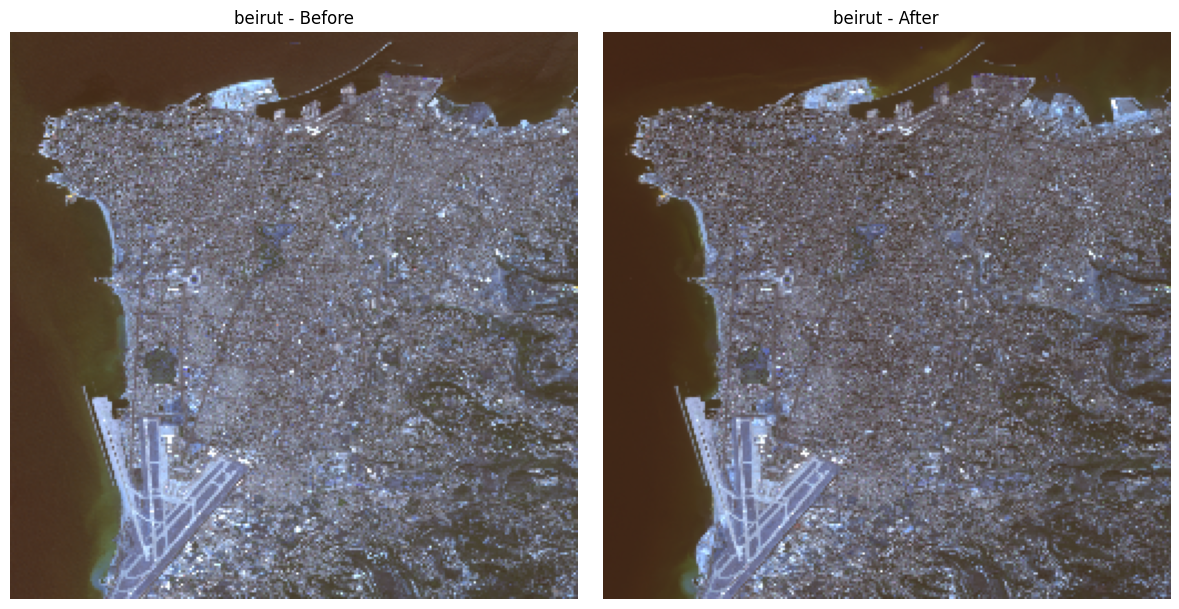


Training cities (12): beirut, cupertino, saclay_e, aguasclaras, bercy, nantes, abudhabi, beihai, rennes, paris, mumbai, bordeaux
Validation cities (2): pisa, hongkong
Test cities (10): rio, saclay_w, chongqing, lasvegas, dubai, valencia, norcia, montpellier, brasilia, milano

Building U-Net model...

Training U-Net model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      4,672 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_9[0][0]  

 Total params: 31,034,625 (118.39 MB)

 Trainable params: 31,034,625 (118.39 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59s/step - accuracy: 0.7252 - loss: 0.6920 - precision: 0.0206 - recall: 0.2583
Epoch 1: val_loss improved from inf to 0.68424, saving model to change_detection_model/best_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 95s 95s/step - accuracy: 0.7252 - loss: 0.6920 - precision: 0.0206 - recall: 0.2583 - val_accuracy: 0.9719 - val_loss: 0.6842 - val_precision: 0.0508 - val_recall: 0.0047
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37s/step - accuracy: 0.9826 - loss: 0.6848 - precision: 0.0419 - recall: 0.0105
Epoch 2: val_loss improved from 0.68424 to 0.67876, saving model to change_detection_model/best_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 48s 48s/step - accuracy: 0.9826 - loss: 0.6848 - precision: 0.0419 - recall: 0.0105 - val_accuracy: 0.9740 - val_loss: 0.6788 - val_precision: 0.2857 - val_recall: 0.0018
Epoch 3/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 3: val_loss did not improve from 0.67876
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9740 - val_loss: 0.6788 - val_precision: 0.2857 - val_recall: 0.0018
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.9784 - loss: 0.6799 - precision: 0.0353 - recall: 9.9538e-04
Epoch 4: val_loss improved from 0.67876 to 0.67353, saving model to change_detection_model/best_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.9784 - loss: 0.6799 - precision: 0.0353 - recall: 9.9538e-04 - val_accuracy: 0.9741 - val_loss: 0.6735 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.9858 - loss: 0.6745 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5: val_loss improved from 0.67353 to 0.66768, saving model to change_detection_model/best_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.9858 - loss: 0.6745 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9741 - val_loss: 0.6677 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/50

Epoch 6: val_loss did not improve from 0.66768
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9741 - val_loss: 0.6677 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.9789 - loss: 0.6688 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 7: val_loss improved from 0.66768 to 0.66097, saving model to change_detection_model/best_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step - accuracy: 0.9789 - loss: 0.6688 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9741 - val_loss: 0.6610 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.9858 - loss: 0.6622 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 8: val_loss improved from 0.66097 to 0.65178, saving model to change_detection_model/best_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.9858 - loss: 0.6622 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9741 - val_loss: 0.6518 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 9/50

Epoch 9: val_loss did not improve from 0.65178
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9741 - val_loss: 0.6518 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37s/step - accuracy: 0.9789 - loss: 0.6515 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 10: val_loss improved from 0.65178 to 0.63746, saving model to change_detection_model/best_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 82s 82s/step - accuracy: 0.9789 - loss: 0.6515 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9741 - val_loss: 0.6375 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.9858 - loss: 0.6365 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 11: val_loss improved from 0.63746 to 0.60935, saving model to change_detection_model/best_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.9858 - loss: 0.6365 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9741 - val_loss: 0.6094 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 12/50

Epoch 12: val_loss did not improve from 0.60935
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9741 - val_loss: 0.6094 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.9789 - loss: 0.5960 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 13: val_loss improved from 0.60935 to 0.54195, saving model to change_detection_model/best_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.9789 - loss: 0.5960 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9741 - val_loss: 0.5419 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.9858 - loss: 0.5020 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 14: val_loss improved from 0.54195 to 0.39412, saving model to change_detection_model/best_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.9858 - loss: 0.5020 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9741 - val_loss: 0.3941 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 15/50

Epoch 15: val_loss did not improve from 0.39412
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9741 - val_loss: 0.3941 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - accuracy: 0.9789 - loss: 0.3033 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 16: val_loss improved from 0.39412 to 0.18481, saving model to change_detection_model/best_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.9789 - loss: 0.3033 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9741 - val_loss: 0.1848 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.9858 - loss: 0.1114 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 17: val_loss did not improve from 0.18481
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.9858 - loss: 0.1114 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9741 - val_loss: 0.2090 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 18/50

Epoch 18: val_loss did not improve from 0.18481
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9741 - val_loss: 0.2090 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.9789 - loss: 0.3195 - precision: 0.0000e+00 - recall: 0.00

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.9789 - loss: 0.2784 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9741 - val_loss: 0.1547 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9858 - loss: 0.1124 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 23: val_loss did not improve from 0.15471
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.9858 - loss: 0.1124 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9741 - val_loss: 0.1775 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 24/50

Epoch 24: val_loss did not improve from 0.15471
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9741 - val_loss: 0.1775 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.9789 - loss: 0.1520 - precision: 0.0000e+00 - recall: 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.9858 - loss: 0.1031 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9741 - val_loss: 0.1496 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 33/50

Epoch 33: val_loss did not improve from 0.14955
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9741 - val_loss: 0.1496 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.9789 - loss: 0.1673 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 34: val_loss did not improve from 0.14955
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.9789 - loss: 0.1673 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9741 - val_loss: 0.1521 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.9858 - loss: 0.1109 - precision: 0.0000e+00 - recall: 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step - accuracy: 0.9789 - loss: 0.1931 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9741 - val_loss: 0.1480 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9858 - loss: 0.1057 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 38: val_loss improved from 0.14799 to 0.14632, saving model to change_detection_model/best_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.9858 - loss: 0.1057 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9741 - val_loss: 0.1463 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 39/50

Epoch 39: val_loss did not improve from 0.14632
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9741 - val_loss: 0.1463 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 40/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.9789 - loss: 0.1561 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 40: val_loss did not improve from 0.14632
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.9789 - loss: 0.1561 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9741 - val_loss: 0.1550 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 41/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.9858 - loss: 0.0981 - precision: 0.0000e+00 - recall: 0.00


Plotting training history...

Loading best model for evaluation...


Loaded best model from change_detection_model/best_model.h5

Evaluating model on test cities...
Evaluating on city: rio
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Evaluating on city: saclay_w
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Evaluating on city: chongqing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Evaluating on city: lasvegas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Evaluating on city: dubai
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Evaluating on city: valencia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Evaluating on city: norcia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Evaluating on city: montpellier
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Evaluating on city: brasilia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Evaluating on city: milano
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    626760
           1       0.00      0.00      0.00     28600

    accuracy                           0.96    655360
  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [44]:
# Run the main program when this script is executed
if __name__ == "__main__":
    main()

# Improvements

In [45]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [46]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [47]:
# Hyperparameters
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3
BATCH_SIZE = 16
EPOCHS = 50
INITIAL_LEARNING_RATE = 0.001
MIN_LEARNING_RATE = 0.00001
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.1

In [ ]:
# Load and preprocess data function - adapt this to your dataset
def load_data(data_path, mask_path=None):
    """
    Load images and masks, preprocess them, and split into train/val/test sets
    """
    # This is a placeholder - replace with your actual data loading code
    print(f"Loading data from {data_path}")

    # Dummy data for demonstration - replace with your actual data loading
    # In a real scenario, you'd load actual images and masks
    num_samples = 200
    images = np.random.random((num_samples, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    masks = np.random.randint(0, 2, (num_samples, IMG_HEIGHT, IMG_WIDTH, 1))

    # Split data into train, validation, and test sets
    train_images, temp_images, train_masks, temp_masks = train_test_split(
        images, masks, test_size=VALIDATION_SPLIT + TEST_SPLIT, random_state=42)

    val_ratio = TEST_SPLIT / (VALIDATION_SPLIT + TEST_SPLIT)
    val_images, test_images, val_masks, test_masks = train_test_split(
        temp_images, temp_masks, test_size=val_ratio, random_state=42)

    print(f"Train: {len(train_images)}, Validation: {len(val_images)}, Test: {len(test_images)}")

    return (train_images, train_masks), (val_images, val_masks), (test_images, test_masks)

In [ ]:
# Data augmentation function
def create_data_generators(train_images, train_masks, val_images, val_masks):
    """
    Create data generators with augmentation for training
    """
    # Image data generator with augmentation for training
    data_gen_args = dict(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Same seed for image and mask generators to ensure same transformation
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    # Validation generators without augmentation
    val_image_datagen = ImageDataGenerator()
    val_mask_datagen = ImageDataGenerator()

    image_generator = image_datagen.flow(
        train_images, batch_size=BATCH_SIZE, seed=42)
    mask_generator = mask_datagen.flow(
        train_masks, batch_size=BATCH_SIZE, seed=42)

    val_image_generator = val_image_datagen.flow(
        val_images, batch_size=BATCH_SIZE, seed=42)
    val_mask_generator = val_mask_datagen.flow(
        val_masks, batch_size=BATCH_SIZE, seed=42)

    # Combine generators into one
    train_generator = zip(image_generator, mask_generator)
    val_generator = zip(val_image_generator, val_mask_generator)

    return train_generator, val_generator

In [ ]:
# Define the U-Net model with improved architecture and regularization
def build_unet_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dropout_rate=0.3):
    """
    Build U-Net model with proper regularization to prevent overfitting
    """
    # Input
    inputs = layers.Input(input_shape)

    # Normalization layer - helps with convergence and regularization
    x = layers.BatchNormalization()(inputs)

    # Encoder (Downsampling path)
    # Block 1
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    drop1 = layers.Dropout(dropout_rate)(pool1)

    # Block 2
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(drop1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    drop2 = layers.Dropout(dropout_rate)(pool2)

    # Block 3
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(drop2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    drop3 = layers.Dropout(dropout_rate)(pool3)

    # Block 4
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(drop3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = layers.BatchNormalization()(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
    drop4 = layers.Dropout(dropout_rate)(pool4)

    # Bridge
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(drop4)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    conv5 = layers.BatchNormalization()(conv5)
    drop5 = layers.Dropout(dropout_rate + 0.1)(conv5)  # Higher dropout at the bottleneck

    # Decoder (Upsampling path)
    # Block 6
    up6 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(drop5)
    merge6 = layers.Concatenate()([conv4, up6])
    drop6 = layers.Dropout(dropout_rate)(merge6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(drop6)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    conv6 = layers.BatchNormalization()(conv6)

    # Block 7
    up7 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = layers.Concatenate()([conv3, up7])
    drop7 = layers.Dropout(dropout_rate)(merge7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(drop7)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    conv7 = layers.BatchNormalization()(conv7)

    # Block 8
    up8 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    merge8 = layers.Concatenate()([conv2, up8])
    drop8 = layers.Dropout(dropout_rate)(merge8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(drop8)
    conv8 = layers.BatchNormalization()(conv8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = layers.BatchNormalization()(conv8)

    # Block 9
    up9 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    merge9 = layers.Concatenate()([conv1, up9])
    drop9 = layers.Dropout(dropout_rate)(merge9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(drop9)
    conv9 = layers.BatchNormalization()(conv9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = layers.BatchNormalization()(conv9)

    # Output layer - sigmoid for binary segmentation
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv9)

    # Create model
    model = models.Model(inputs=inputs, outputs=outputs)

    return model

In [ ]:
# Custom IoU metric
def iou_metric(y_true, y_pred, smooth=1):
    """
    Calculate IoU (Intersection over Union) metric
    """
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Threshold at 0.5
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

In [ ]:
# Custom Dice coefficient metric
def dice_coef(y_true, y_pred, smooth=1):
    """
    Calculate Dice coefficient metric
    """
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Threshold at 0.5
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

In [ ]:
# Custom loss function - weighted binary crossentropy + dice loss
def combined_loss(y_true, y_pred):
    """
    Combine binary crossentropy and dice loss for better handling of class imbalance
    """
    # Binary crossentropy
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)

    # Dice loss
    dice_loss = 1 - dice_coef(y_true, y_pred)

    # Combined loss with weighting
    return 0.5 * bce + 0.5 * dice_loss

In [ ]:
# Function to create a learning rate scheduler
def create_lr_scheduler():
    """
    Create a learning rate scheduler that reduces LR on plateau
    """
    return callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        verbose=1,
        min_lr=MIN_LEARNING_RATE
    )

In [ ]:
# Function to create early stopping
def create_early_stopping():
    """
    Create early stopping to prevent overfitting
    """
    return callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        verbose=1,
        restore_best_weights=True
    )

In [ ]:
# Function to create model checkpoint
def create_checkpoint_callback(checkpoint_path):
    """
    Create model checkpoint to save the best model
    """
    os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
    return callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        mode='min'
    )

In [ ]:
# Function to create TensorBoard callback
def create_tensorboard_callback(log_dir):
    """
    Create TensorBoard callback for monitoring training
    """
    os.makedirs(log_dir, exist_ok=True)
    return callbacks.TensorBoard(
        log_dir=log_dir,
        histogram_freq=1,
        write_graph=True,
        update_freq='epoch'
    )

In [ ]:
# Function to plot training history
def plot_training_history(history):
    """
    Plot training and validation metrics
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss
    ax1.plot(history.history['loss'], label='Train Loss')
    ax1.plot(history.history['val_loss'], label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_title('Training and Validation Loss')
    ax1.grid(True)

    # Plot IoU / Dice
    if 'iou_metric' in history.history:
        ax2.plot(history.history['iou_metric'], label='Train IoU')
        ax2.plot(history.history['val_iou_metric'], label='Val IoU')
        metric_name = 'IoU'
    elif 'dice_coef' in history.history:
        ax2.plot(history.history['dice_coef'], label='Train Dice')
        ax2.plot(history.history['val_dice_coef'], label='Val Dice')
        metric_name = 'Dice Coefficient'
    else:
        ax2.plot(history.history['accuracy'], label='Train Accuracy')
        ax2.plot(history.history['val_accuracy'], label='Val Accuracy')
        metric_name = 'Accuracy'

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel(metric_name)
    ax2.legend()
    ax2.set_title(f'Training and Validation {metric_name}')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
# Function to evaluate model on test data
def evaluate_model(model, test_images, test_masks):
    """
    Evaluate model on test data and print metrics
    """
    # Get predictions
    test_pred_masks = model.predict(test_images)
    test_pred_masks_binary = (test_pred_masks > 0.5).astype(np.uint8)

    # Reshape for classification metrics
    test_masks_flat = test_masks.reshape(-1)
    test_pred_masks_flat = test_pred_masks_binary.reshape(-1)

    # Calculate IoU and Dice manually
    intersection = np.logical_and(test_masks_flat, test_pred_masks_flat).sum()
    union = np.logical_or(test_masks_flat, test_pred_masks_flat).sum()
    iou = intersection / union if union > 0 else 0

    dice = 2 * intersection / (test_masks_flat.sum() + test_pred_masks_flat.sum()) if (test_masks_flat.sum() + test_pred_masks_flat.sum()) > 0 else 0

    print(f"Test IoU: {iou:.4f}")
    print(f"Test Dice Coefficient: {dice:.4f}")

    # Classification metrics
    print("\nClassification Report:")
    print(classification_report(test_masks_flat, test_pred_masks_flat))

    # Confusion Matrix
    cm = confusion_matrix(test_masks_flat, test_pred_masks_flat)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Display sample predictions
    display_sample_predictions(test_images, test_masks, test_pred_masks_binary, num_samples=4)

# Function to display sample predictions
def display_sample_predictions(images, true_masks, pred_masks, num_samples=4):
    """
    Display sample predictions from the test set
    """
    indices = np.random.choice(range(len(images)), num_samples, replace=False)

    plt.figure(figsize=(15, 4 * num_samples))

    for i, idx in enumerate(indices):
        # Original image
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(images[idx])
        plt.title(f"Image {idx}")
        plt.axis('off')

        # True mask
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(true_masks[idx, :, :, 0], cmap='gray')
        plt.title(f"True Mask {idx}")
        plt.axis('off')

        # Predicted mask
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred_masks[idx, :, :, 0], cmap='gray')
        plt.title(f"Predicted Mask {idx}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# Main execution function
def train_and_evaluate_unet(data_path, mask_path=None,
                           output_dir="unet_model",
                           use_class_weights=True,
                           dropout_rate=0.3):
    """
    Main function to train and evaluate U-Net model
    """
    # Create output directories
    checkpoint_path = os.path.join(output_dir, "checkpoints", "model.h5")
    log_dir = os.path.join(output_dir, "logs")
    os.makedirs(os.path.join(output_dir, "checkpoints"), exist_ok=True)
    os.makedirs(log_dir, exist_ok=True)

    # Load and preprocess data
    (train_images, train_masks), (val_images, val_masks), (test_images, test_masks) = load_data(data_path, mask_path)

    # Create data generators with augmentation
    train_generator, val_generator = create_data_generators(train_images, train_masks, val_images, val_masks)

    # Build model
    model = build_unet_model(dropout_rate=dropout_rate)

    # Compile model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE),
        loss=combined_loss,
        metrics=[iou_metric, dice_coef, 'accuracy']
    )

    # Model summary
    model.summary()

    # Calculate class weights if enabled
    class_weights = None
    if use_class_weights:
        # Calculate positive and negative pixel counts
        pos_pixels = np.sum(train_masks)
        neg_pixels = np.size(train_masks) - pos_pixels

        # Calculate class weights
        weight_for_0 = (1 / neg_pixels) * np.size(train_masks) / 2.0
        weight_for_1 = (1 / pos_pixels) * np.size(train_masks) / 2.0

        class_weights = {0: weight_for_0, 1: weight_for_1}
        print(f"Class weights: {class_weights}")

    # Setup callbacks
    callbacks_list = [
        create_lr_scheduler(),
        create_early_stopping(),
        create_checkpoint_callback(checkpoint_path),
        create_tensorboard_callback(log_dir)
    ]

    # Train model
    print("Starting model training...")
    steps_per_epoch = len(train_images) // BATCH_SIZE
    validation_steps = len(val_images) // BATCH_SIZE

    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_generator,
        validation_steps=validation_steps,
        callbacks=callbacks_list,
        class_weight=class_weights
    )

    # Plot training history
    plot_training_history(history)

    # Evaluate model on test data
    print("Evaluating model on test data...")
    evaluate_model(model, test_images, test_masks)

    # Save model
    model.save(os.path.join(output_dir, "final_model.h5"))
    print(f"Model saved to {os.path.join(output_dir, 'final_model.h5')}")

    return model, history

In [ ]:
# Example usage
if __name__ == "__main__":
    # Replace with your actual data path
    data_path = "path/to/images"
    mask_path = "path/to/masks"

    # Train and evaluate model
    model, history = train_and_evaluate_unet(
        data_path=data_path,
        mask_path=mask_path,
        output_dir="unet_results",
        use_class_weights=True,
        dropout_rate=0.3
    )